# Cluster visualization

This is a continuation of [dc recommendations.ipynb](dc%20recommendations.ipynb)...

In this worksheet, we present a visualization of the 2500-dimensional vectors representing projects that are related via donations from particular donors.


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

# 1.1m rows
projects_ff = pd.read_csv('Projects.csv')
# 4.6m rows
donations_ff = pd.read_csv('Donations.csv')
# Some donations were missing valid project IDs...
df = donations_ff.merge(projects_ff, on="Project ID", how="inner")
df.head(3)

# REDUCED SIZE FOR TESTING/DEVELOPMENT
donations = df.sample(n=50000)[['Project ID', 'Donation ID', 'Donor ID', 'Donation Amount', 'Donation Received Date']]

projects = projects_ff.loc[ projects_ff["Project ID"].isin(donations["Project ID"]) ].copy()
projects = projects.reset_index(drop = True)

print(" loaded", len(donations), "donations and", len(projects), "projects.")

 loaded 50000 donations and 46575 projects.


In [27]:
#
# Model training
#

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Preprocessing of text data
textfeats = ["Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently 
text = pd.Series(projects["Project Essay"])

basic_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english')
tuned_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english', 
                                   ngram_range = (1,3), max_features=2500 )
vectorizer = tuned_vectorizer

PF_MATRIX = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()

project_row_to_id = dict(projects['Project ID'])
project_id_to_row = {value: key for key, value in project_row_to_id.items()}

PF_MATRIX


<46575x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 4712748 stored elements in Compressed Sparse Row format>

In [28]:
##
## Split the donations
##
from sklearn.model_selection import train_test_split 

donations_train, donations_test = train_test_split(donations, test_size=0.5)
print(len(donations_train), len(donations_test))

def get_future_donation_rows(donor_id):
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_test["Project ID"].map(project_id_to_row))

def get_past_donation_rows(donor_id):
    donor_projects_train = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_train["Project ID"].map(project_id_to_row))


25000 25000


This is the list of top donors as ranked by the number of projects to which they have each contributed.

In [29]:
##
## Find the top donors (by number of projects)
##

MIN_FREQ = 3

top_donors = pd.DataFrame(donations_train['Donor ID'].value_counts())
top_donors.columns = ['freq']
top_donors['Donor ID'] = top_donors.index
top_donors = top_donors.loc[top_donors.freq >= MIN_FREQ]

td_test = pd.DataFrame(donations_test.merge( top_donors, on="Donor ID", how="inner" ).groupby("Donor ID")["Project ID"].count())
td_test.columns = ['test_freq']
td_test = td_test.loc[td_test.test_freq >= MIN_FREQ]

top_donors = top_donors.merge(td_test, on="Donor ID", how="inner")
top_donors[:20]



,freq,Donor ID,test_freq
0,104,39df9399f5384334a42905bcf0acdcbf,96
1,79,237db43817f34988f9d543ca518be4ee,87
2,51,6f74ffb17cbb2b616b1eef06bd4acd0c,45
3,51,a0e1d358aa17745ff3d3f4e4909356f3,60
4,42,24ecca49933c30a0beb83090591720c0,40
5,40,a1929a1172ad0b3d14bc84f54018c563,31
6,37,19f24640d9da49f6f8b4c9938c049591,29
7,32,6a35a7514005c04f8520e5d8f7657d91,26
8,31,6dd7995a998f79a8c65a0d400c9a5350,12
9,29,eecc14ded80a38f692a590fe80c7b08f,22


Here, we choose two different top donors.  For each of them, we look up the **training/past** projects and the **test/future** projects to which they donated.

Then we visualize these in 2-D space using UMAP.  If there is good signal, we hope to see the training/test sets for each donor overlap but also would like to see separation between the clusters for the two donors.


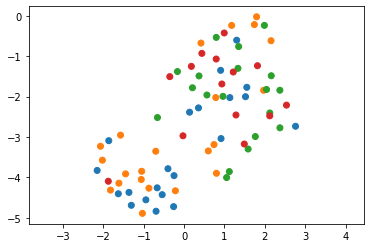

In [39]:
import random
import umap
import seaborn as sns

cnt = 0
plot_data = pd.DataFrame()

for tid in [top_donors.iloc[random.choice(range(20))]["Donor ID"], top_donors.iloc[random.choice(range(20))]["Donor ID"] ]:
    X = PF_MATRIX[np.array(get_past_donation_rows(tid)),:]
    Y = PF_MATRIX[np.array(get_future_donation_rows(tid)),:]
    pdata = pd.DataFrame(X.todense())
    pdata["target"] = cnt
    cnt += 1
    qdata = pd.DataFrame(Y.todense())
    qdata["target"] = cnt
    cnt += 1
    plot_data = plot_data.append(pdata)
    plot_data = plot_data.append(qdata)
#plot_data

reducer = umap.UMAP()
embedding = reducer.fit_transform(plot_data.drop(['target'], axis=1))

plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in plot_data.target])
plt.gca().set_aspect('equal', 'datalim')
